# The Importance of Time Series Analysis in Quantitative Finance

## Introduction

In quantitative finance, time series analysis plays a pivotal role in understanding and forecasting financial data over time. Financial markets are inherently dynamic, with asset prices, interest rates, and volatility fluctuating continuously. Time series analysis enables analysts and traders to detect patterns, estimate future prices, and develop strategies based on the historical behavior of financial instruments.

By modeling the temporal dependence in financial data, time series analysis helps to capture trends, cycles, and volatility structures, which are crucial for pricing, risk management, and trading decisions. Common techniques used in time series analysis include:

- **ARIMA** (AutoRegressive Integrated Moving Average)
- **GARCH** (Generalized Autoregressive Conditional Heteroskedasticity)
- **Exponential Smoothing**

This assignment explores ARIMA time series modeling techniques and provide a real-world example of predicting stock prices to inform trading decisions.

### ARIMA (AutoRegressive Integrated Moving Average)

ARIMA is one of the most popular techniques for time series forecasting, especially for data that shows temporal autocorrelation. ARIMA models can capture different patterns, including trends, seasonalities, and noise, making it a versatile tool in finance.

The ARIMA model consists of three key components:

- **AR (AutoRegressive)**: This part models the dependency between an observation and a certain number of lagged observations (previous values of the time series).
  
- **I (Integrated)**: The "integrated" part refers to differencing the data to make the time series stationary (i.e., removing trends and seasonality).

- **MA (Moving Average)**: This part models the dependency between an observation and the residual errors from previous time steps.

The notation for ARIMA is typically expressed as ARIMA(p, d, q), where:

- **p**: The number of lag terms (autoregressive component).
- **d**: The number of differencing steps needed to make the series stationary.
- **q**: The number of lagged forecast errors (moving average component).

### Finance Analogy

Consider a stock price that shows a trend over time with small deviations due to random market factors. The AR component explains how past prices influence the current price, while the MA component captures how past errors (unexpected price movements) affect the forecast. The I component helps remove the trend, allowing us to forecast future stock prices by focusing on deviations from the historical pattern.

### Example in Trading

In stock trading, ARIMA can be used to predict short-term price movements. By training an ARIMA model on historical prices, traders can generate future price forecasts and develop strategies, such as entering buy/sell positions based on predicted price trends.

## -----------------------------------------------------------------------------------------

## -----------------------------------------------------------------------------------------

### Quant Take Home Assessment for Sixpoint Capital Mangement

### Python Class for Time Series Analysis

Create a Python class that can perform the following functionalities:

### Class Overview

The class should include the following methods:

1. **Initialization**
   - Take as input a time series.

2. **Stationarity Evaluation**
   - Evaluate whether the series is stationary or not.

3. **Differencing**
   - Allow the user to difference the series.

4. **ARIMA Model Evaluation**
   - Evaluate different ARIMA time series models.

5. **Best Model Selection**
   - Automatically select and estimate the “best” ARIMA time series model using a method. The criteria for the “best” model are:
     - The model with the lowest AIC.
     - No insignificant terms according to a user-specified p-value.

6. **Forecast Simulation**
   - Simulate forecasts of the time series model with the following parameters:
     - The number of forecasts (e.g., user can specify 10,000 simulations).
     - The number of forecast periods (e.g., user specifies forecasting 10 periods ahead).
     - Ensure the distribution of the noise term in the forecast matches the distribution of the residuals (i.e., they should not be normally distributed).
     - Avoid sampling with replacement as a solution.

7. **Exceedance Calculation**
   - Calculate what percentage of simulations exceed a user-specified value in each forecast period.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

import warnings
warnings.filterwarnings('ignore')

class ARIMAStockForecasting:
    # Initializing control variables, providing more flexible forecasting 
    def __init__(self, ticker, start_date, end_date, interval, num_simulations, forecast_periods, threshold_value, p_value_threshold, risk_free_rate):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.num_simulations = num_simulations
        self.forecast_periods = forecast_periods
        self.threshold_value = threshold_value
        self.p_value_threshold = p_value_threshold
        self.risk_free_rate = risk_free_rate
        self.data = None
        self.data_diff = None
        self.best_model = None
        self.best_order = None
        self.predictions_df = None  # To store forecasted prices

    def download_stock_data(self):
        # Fetching Tesla time-series stock data to forecast
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date, interval=self.interval)['Close']
        # print(self.data)

    def apply_log_transform(self):
        self.data = np.log(self.data)
        # self.data_diff = self.data.diff().dropna()

    def check_stationarity(self):
        """
        ADF Test: We employ the Augmented Dickey-Fuller (ADF) test, a popular statistical test used to check for stationarity. 
        The test aims to determine whether a unit root is present in the series, which is indicative of non-stationarity.
    
        Interpretation: If the ADF test shows that the data does not contain a unit root, the series can be considered stationary, 
        and models like ARMA (Autoregressive Moving Average) are suitable.
        
        Differencing: If the test indicates non-stationarity, we proceed by differencing the data. 
        This involves subtracting the previous observation from the current observation. 
        We then reapply the ADF test to the differenced data to check for stationarity again.
        
        Model Application: If the differenced data is stationary, we use an ARIMA (Autoregressive Integrated Moving Average) model, 
        which integrates the differencing step into the modeling process.
        This approach ensures that the time series model is built on a solid foundation of data that meets the necessary statistical properties, 
        enhancing the reliability and accuracy of the forecasts
    
        """
        result = sm.tsa.stattools.adfuller(self.data.dropna())
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:', result[4])
        return result[1] < 0.05  # Returns True if the series is stationary

    def check_seasonality(self):
        seasonal_decompose = sm.tsa.seasonal_decompose(self.data, model='additive', period=12)  # Adjust period as needed
        seasonal_decompose.plot()
        plt.title('Seasonal Decomposition of Time Series')
        plt.show()
        return seasonal_decompose.seasonal.mean()  # Returns the average seasonal component

    def difference_series(self):
        self.data_diff = self.data.diff().dropna()
        print("Series differenced to make it stationary.")

    def plot_acf_pacf(self):

        """
        ACF is used to identify the moving average component of an ARIMA model, denoted as (q). 
        It shows the extent of correlation between a variable and its lag across successive time intervals. 
        If the ACF shows a gradual decline, it suggests a moving average process might be suitable

        PACF is primarily used to determine the order of the autoregressive component of an ARIMA model, denoted as (p). 
        A sharp cut-off in the PACF after a certain number of lags suggests the order of the AR process.
        
        """ 
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plot_acf(self.data_diff, ax=plt.gca(), lags=40)
        plt.title('Autocorrelation Function (ACF)')
        plt.subplot(122)
        plot_pacf(self.data_diff, ax=plt.gca(), lags=40)
        plt.title('Partial Autocorrelation Function (PACF)')
        plt.show()

    def fit_arima_model(self):
        """
        1. p: The number of past observations (we usually call them lagged terms) of the process included in the model.
        2. d: The number of times we difference the original process to make it stationary.
        3. q: The number of past error terms (we usually call them lagged error terms or lagged residuals) of the process included in the model.
        """
        p_range = range(0, 6) 
        d_range = range(0, 2)
        q_range = range(0, 6)

        best_aic = np.inf
        best_bic = np.inf

        for p in p_range:
            for d in d_range:
                for q in q_range:
                    try:
                        model = ARIMA(self.data, order=(p, d, q)).fit()
                        current_aic = model.aic
                        current_bic = model.bic
                        significant_terms = model.pvalues[model.pvalues < self.p_value_threshold].count() == len(model.pvalues)

                        if current_aic < best_aic and significant_terms:
                            best_aic = current_aic
                            best_bic = current_bic
                            self.best_order = (p, d, q)
                            self.best_model = model
                        print(f"ARIMA({p},{d},{q}) - AIC: {current_aic}, BIC: {current_bic}, Significant Terms: {significant_terms}")
                    except Exception as e:
                        print(f"ARIMA({p},{d},{q}) failed: {e}")
                        continue

        if self.best_model is not None:
            print(f"\nBest ARIMA model: {self.best_order} with AIC: {best_aic} and BIC: {best_bic}")
        else:
            print("No suitable ARIMA model found.")

    def plot_diagnostics(self):
        if self.best_model is not None:
            print(self.best_model.summary())
            self.best_model.plot_diagnostics(figsize=(15, 8))
            plt.show()

    def calculate_error_metrics(self):
        if self.best_model is not None:
            actual = self.data[self.best_model.fittedvalues.index]
            fitted = self.best_model.fittedvalues
            
            mse = mean_squared_error(actual, fitted)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(actual, fitted)
            mape = np.mean(np.abs((actual - fitted) / actual)) * 100
            
            print(f"MSE: {mse}")
            print(f"RMSE: {rmse}")
            print(f"MAE: {mae}")
            print(f"MAPE: {mape}%")

    def plot_residuals(self):
        if self.best_model is not None:
            residuals = pd.DataFrame(self.best_model.resid)
            # residuals.plot(title="Residuals")
            # plt.show()

    def apply_garch(self):
        """ 
        GARCH Interpretation:

	    Conditional Volatility: The GARCH model provides the conditional volatility,
        which measures the changing level of risk or variability in the time series. 
        We can analyze how volatility evolves over time based on this model.
        
        """    

        if self.best_model is not None:
            # Fit GARCH model to ARIMA residuals
            residuals = self.best_model.resid
            garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
            garch_fit = garch_model.fit(disp="off")
            print(garch_fit.summary())
            return garch_fit

    def forecast(self):
        # Generate forecast for the specified periods
        if self.best_model is not None:
            forecast = self.best_model.get_forecast(steps=self.forecast_periods)
            forecast_mean = forecast.predicted_mean
            forecast_index = pd.date_range(start=self.data.index[-1], periods=self.forecast_periods, freq='M')

            # Create a DataFrame with the forecasted values
            self.predictions_df = pd.DataFrame({'Date': forecast_index, 'predicted_price': np.exp(forecast_mean)})
            self.predictions_df.set_index('Date', inplace=True)

            # # Plotting the actual, fitted, and forecasted values
            # plt.figure(figsize=(10, 6))
            # plt.plot(self.data.index, np.exp(self.data), label='Actual Price', color='blue')
            # plt.plot(self.best_model.fittedvalues.index, np.exp(self.best_model.fittedvalues), color='red', label='Fitted Price')
            # plt.plot(self.predictions_df.index, self.predictions_df['predicted_price'], color='green', label='Forecasted Price')
            # plt.fill_between(self.predictions_df.index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
            # plt.legend()
            # plt.title('Actual vs Fitted and Forecasted Values')
            # plt.show()
            return self.predictions_df
        

    def simulate_predictions(self):
        if self.best_model is not None:
            forecast = self.best_model.get_forecast(steps=self.forecast_periods)
            forecast_mean = forecast.predicted_mean
            residuals = self.best_model.resid

            # Block bootstrap parameters
            block_size = 5  # Number of consecutive residuals to sample as a block
            num_blocks = len(residuals) // block_size

            def moving_block_bootstrap(residuals, block_size, periods):
                """Generates bootstrapped residuals using moving block bootstrap."""
                indices = np.random.choice(range(num_blocks), size=periods, replace=True)
                bootstrap_residuals = np.concatenate([residuals[i * block_size:(i + 1) * block_size] for i in indices])
                return bootstrap_residuals[:periods]

            simulations = []
            for i in range(self.num_simulations):
                simulated_residuals = moving_block_bootstrap(residuals, block_size, self.forecast_periods)
                simulated_values = forecast_mean + simulated_residuals  # Adding noise for simulated forecasts
                simulations.append(simulated_values)

            simulations = np.array(simulations)

            exceed_percentages = (simulations > self.threshold_value).mean(axis=0) * 100
            simulation_df = pd.DataFrame(simulations, columns=[f"Period {i + 1}" for i in range(self.forecast_periods)])
            exceed_df = pd.DataFrame({"Period": range(1, self.forecast_periods + 1), "Exceed %": exceed_percentages})

            forecast_index = pd.date_range(start=self.data.index[-1] + pd.DateOffset(months=1), periods=self.forecast_periods, freq='M')

            # Plot the original log-transformed series
            plt.figure(figsize=(12, 8))
            plt.plot(self.data, label='Actual', color='blue')
            plt.plot(self.best_model.fittedvalues, color='red', label='Fitted')

            for i in range(simulation_df.shape[0]):
                plt.plot(forecast_index, simulation_df.iloc[i], color='green', alpha=0.1)

            mean_simulation = simulation_df.mean(axis=0)
            plt.plot(forecast_index, mean_simulation, color='orange', label='Mean Simulated Forecast', linewidth=2)

            conf_int = forecast.conf_int()
            plt.plot(forecast_index, forecast.predicted_mean, color='black', label='Forecasted Mean', linewidth=2)
            plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')

            plt.legend()
            plt.title('Actual vs Fitted and Simulated Forecasts (Log-Transformed)')
            plt.xlabel('Date')
            plt.ylabel('Value (Log-Transformed)')
            plt.xticks(rotation=45)
            plt.grid()
            plt.show()

            # Plotting actual price (exp-transformed values)
            plt.figure(figsize=(12, 8))
            plt.plot(np.exp(self.data), label='Actual Price', color='blue')
            plt.plot(np.exp(self.best_model.fittedvalues), color='red', label='Fitted Price')

            for i in range(simulation_df.shape[0]):
                plt.plot(forecast_index, np.exp(simulation_df.iloc[i]), color='green', alpha=0.1)

            mean_simulation_exp = np.exp(mean_simulation)
            plt.plot(forecast_index, mean_simulation_exp, color='orange', label='Mean Simulated Forecast Price', linewidth=2)

            conf_int_exp = np.exp(conf_int)
            plt.plot(forecast_index, np.exp(forecast.predicted_mean), color='black', label='Forecasted Mean Price', linewidth=2)
            plt.fill_between(forecast_index, conf_int_exp.iloc[:, 0], conf_int_exp.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
            plt.ylim(0, 500)  # Compress Y-axis range from 0 to 250
            plt.legend()
            plt.title('Actual vs Fitted and Simulated Forecasts (Actual Price)')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.xticks(rotation=45)
            plt.grid()
            plt.show()

            # Plotting the exceedance percentages
            plt.figure(figsize=(10, 6))
            plt.plot(exceed_df['Period'], exceed_df['Exceed %'], marker='o', linestyle='-', color='blue')
            plt.title(f'Percentage of Simulations Exceeding {self.threshold_value}$')
            plt.xlabel('Forecast Period')
            plt.ylabel('Exceedance Percentage (%)')
            plt.grid(True)
            plt.show()

    def run(self):
        self.download_stock_data()
        self.apply_log_transform()
        if not self.check_stationarity():
            print("The series is not stationary. Checking for seasonality...")
            self.check_seasonality()
            self.difference_series()  # Allow user to decide whether to difference after checking seasonality
        self.plot_acf_pacf()
        self.fit_arima_model()
        self.plot_diagnostics()
        self.calculate_error_metrics()
        self.plot_residuals()
        # self.apply_garch()
        self.forecast()
        self.simulate_predictions()
        # trading_data = self.generate_trading_strategy()
        # if trading_data is not None:
        #     print(trading_data.tail())

[*********************100%***********************]  1 of 1 completed


ADF Statistic: 1.387666303049852
p-value: 0.9970573852819008
Critical Values: {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}
The series is not stationary. Checking for seasonality...


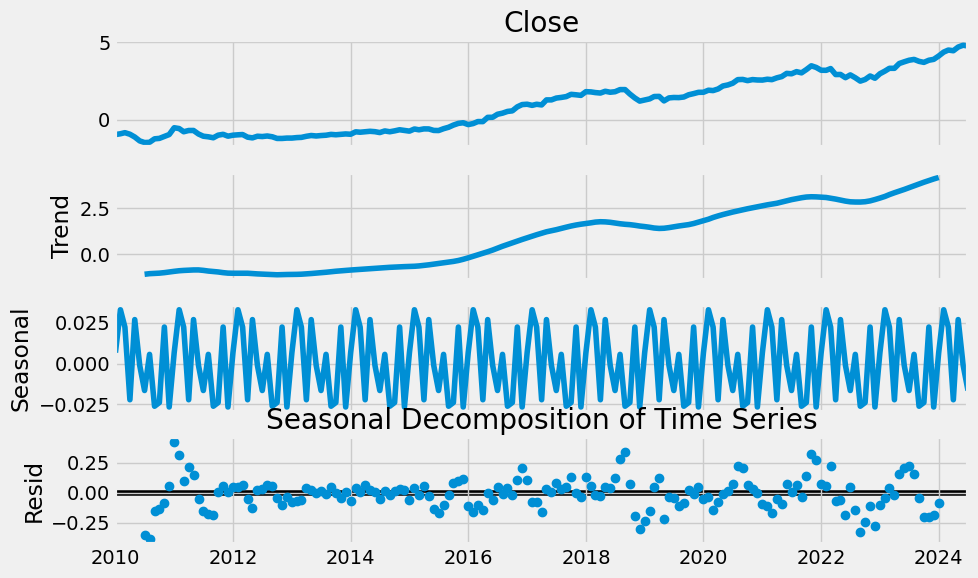

Series differenced to make it stationary.


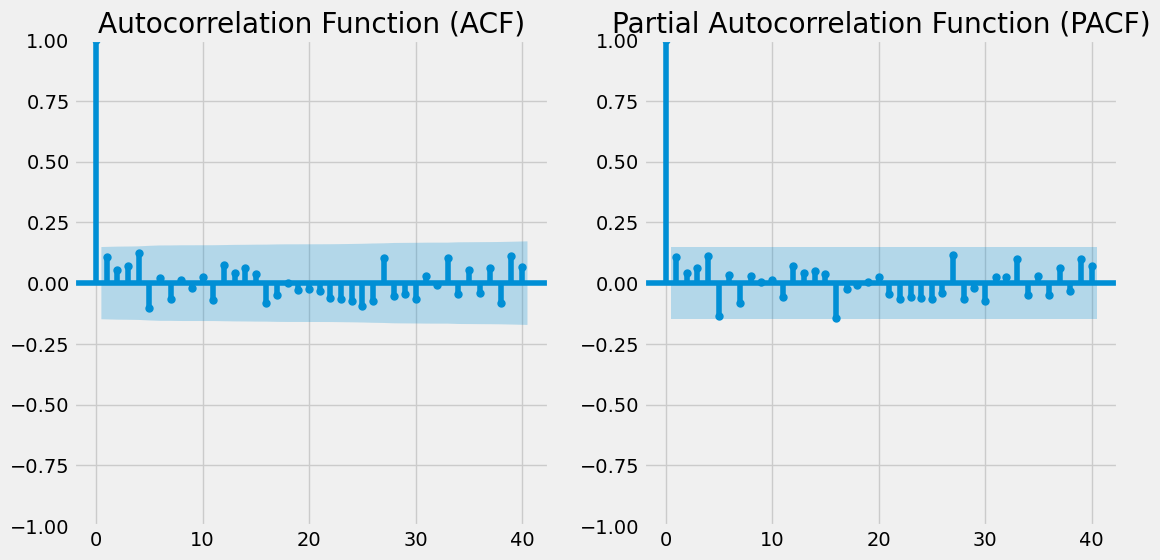

ARIMA(0,0,0) - AIC: 705.6560754420791, BIC: 711.9856473899262, Significant Terms: True
ARIMA(0,0,1) - AIC: 487.8874744290482, BIC: 497.38183235081874, Significant Terms: True
ARIMA(0,0,2) - AIC: 306.8463651656417, BIC: 319.5055090613358, Significant Terms: True
ARIMA(0,0,3) - AIC: 196.74161431093432, BIC: 212.5655441805519, Significant Terms: True
ARIMA(0,0,4) - AIC: 107.08595808338416, BIC: 126.07467392692524, Significant Terms: True
ARIMA(0,0,5) - AIC: 51.12005755430491, BIC: 73.27355937176951, Significant Terms: True
ARIMA(0,1,0) - AIC: -210.62138073221598, BIC: -207.46232543300147, Significant Terms: True
ARIMA(0,1,1) - AIC: -212.6181955415022, BIC: -206.30008494307313, Significant Terms: False
ARIMA(0,1,2) - AIC: -211.58281852916824, BIC: -202.10565263152466, Significant Terms: False
ARIMA(0,1,3) - AIC: -210.76324772829827, BIC: -198.12702653144015, Significant Terms: False
ARIMA(0,1,4) - AIC: -214.86834730220534, BIC: -199.0730708061327, Significant Terms: False
ARIMA(0,1,5) - AI

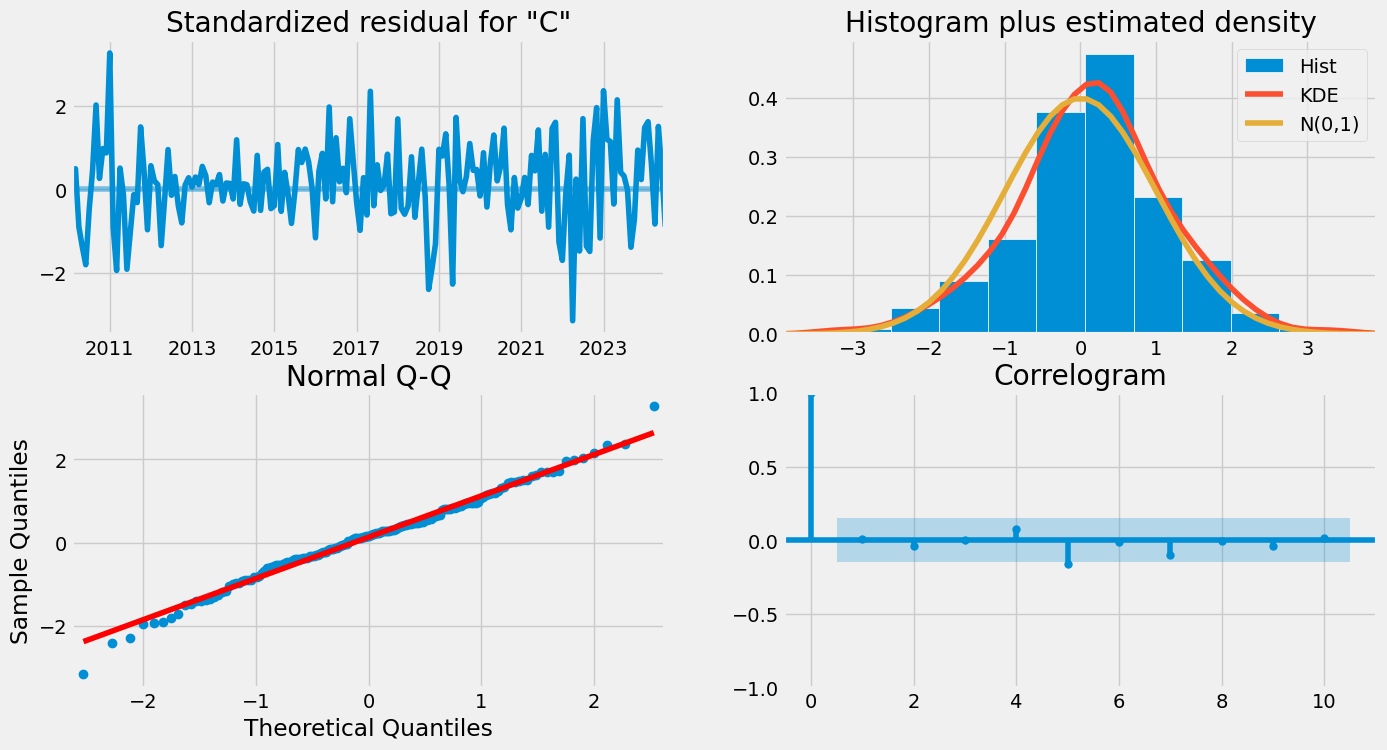

MSE: 0.02150125602830254
RMSE: 0.14663306594456293
MAE: 0.10399154403179824
MAPE: 10.13276873432004%


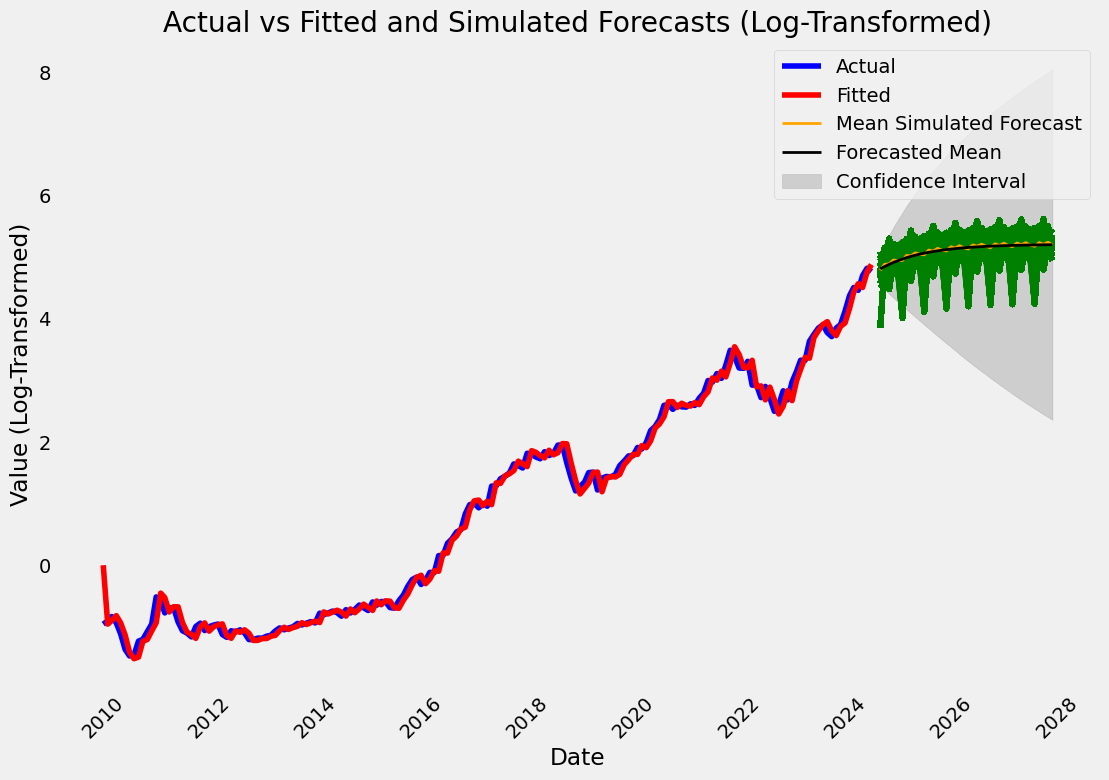

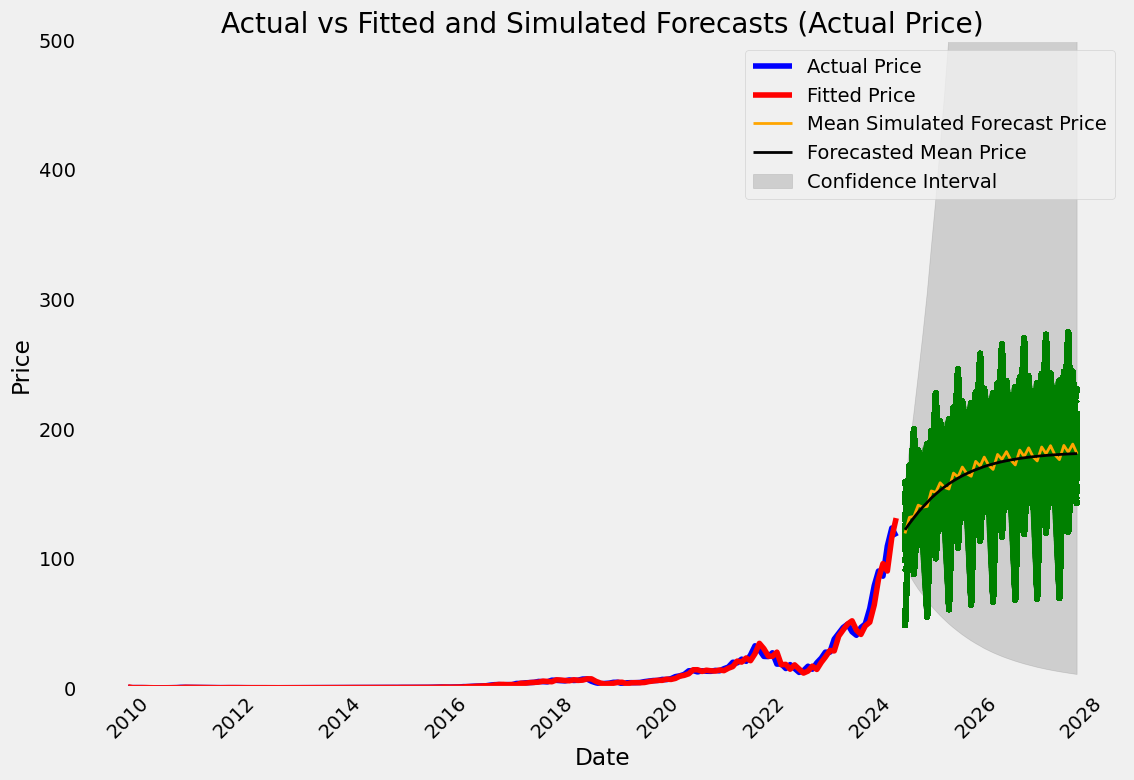

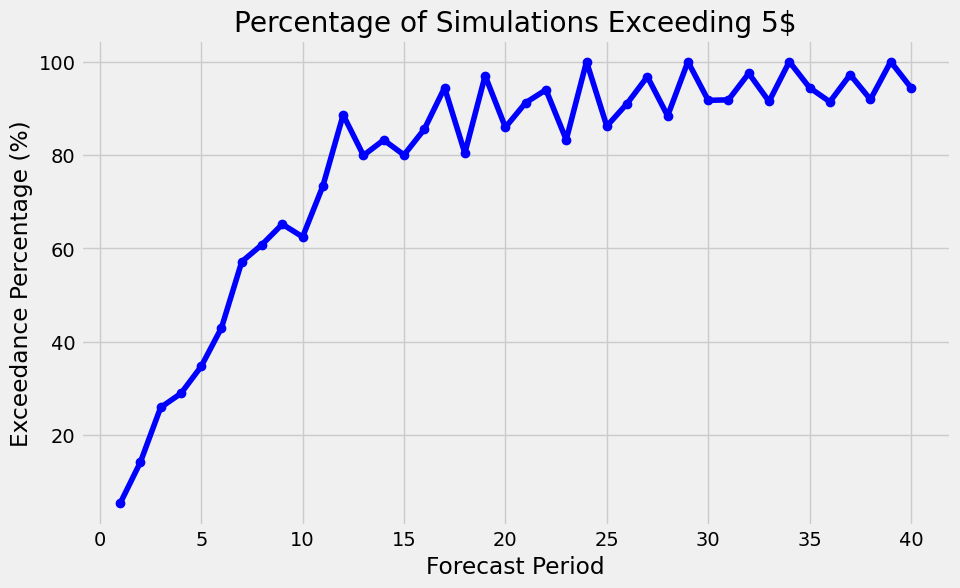

In [37]:

model = ARIMAStockForecasting(
    ticker='NVDA',      # Choose ticker: GOOGL, AMZN, MSFT, TSLA, NVDA
    start_date='2010-01-01', #Sampling Period
    end_date='2024-07-31',
    interval='1mo', # 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
    num_simulations=10000, # Number of simulations
    forecast_periods=40, # unit depends on interval 
    threshold_value=5, # stock price threhold in $
    p_value_threshold=0.05, #pvalue threhold
    risk_free_rate = 0  #just in case if want to calculate sharp ratio
    
)

model.run()

Let's break down the SARIMAX results for the ARIMA(1, 1, 1) model in detail.

### Model Summary

1. **Dependent Variable**: 
   - **Close**: This indicates that the model is predicting the closing prices of the dataset used.

2. **Number of Observations**: 
   - **175**: The model is built on 175 observations of the closing price data.

3. **Model**: 
   - **ARIMA(1, 1, 1)**: This denotes the model structure:
     - **AR (1)**: 1 autoregressive term.
     - **I (1)**: The series has been differenced once to make it stationary.
     - **MA (1)**: 1 moving average term.

4. **Log Likelihood**: 
   - **110.795**: This value represents the log of the likelihood function for the fitted model, indicating how well the model fits the data. Higher values suggest a better fit.

5. **Information Criteria**:
   - **AIC (Akaike Information Criterion)**: **-215.589**: Lower AIC values indicate a better fit, taking into account the complexity of the model. AIC penalizes for the number of parameters, so it's useful for model selection.
   - **BIC (Bayesian Information Criterion)**: **-206.112**: Like AIC, BIC also penalizes for complexity but does so more heavily. Lower values are better, and BIC tends to favor simpler models compared to AIC.
   - **HQIC (Hannan-Quinn Information Criterion)**: **-211.745**: Similar to AIC and BIC, but with a different penalty scheme. 

### Coefficients

1. **AR Term (ar.L1)**:
   - **Coefficient**: **0.9034**
   - **Standard Error**: **0.093**
   - **Z-Value**: **9.692**
   - **P-Value**: **0.000**
   - **Confidence Interval**: [0.721, 1.086]
   - **Interpretation**: The AR term is statistically significant (p < 0.05), indicating a strong positive autocorrelation. The coefficient being close to 1 suggests that past values have a strong influence on the current value.

2. **MA Term (ma.L1)**:
   - **Coefficient**: **-0.8037**
   - **Standard Error**: **0.123**
   - **Z-Value**: **-6.551**
   - **P-Value**: **0.000**
   - **Confidence Interval**: [-1.044, -0.563]
   - **Interpretation**: The MA term is also statistically significant (p < 0.05). A negative coefficient indicates that shocks (or noise) from previous periods have a dampening effect on current values.

3. **Variance (sigma2)**:
   - **Coefficient**: **0.0164**
   - **Standard Error**: **0.002**
   - **Z-Value**: **10.252**
   - **P-Value**: **0.000**
   - **Confidence Interval**: [0.013, 0.020]
   - **Interpretation**: This represents the estimated variance of the residuals. A small positive value indicates the model's expected level of variability around the predicted values.

### Model Diagnostics

1. **Ljung-Box Test (Q)**:
   - **L1**: **0.01**
   - **Prob(Q)**: **0.93**
   - **Interpretation**: The Ljung-Box test checks for the presence of autocorrelation in the residuals. A high p-value (greater than 0.05) suggests that the residuals are independently distributed, indicating a good model fit.

2. **Jarque-Bera Test**:
   - **JB**: **3.16**
   - **Prob(JB)**: **0.21**
   - **Interpretation**: This test checks for normality in the residuals. The p-value indicates that we cannot reject the null hypothesis of normality, which is a desirable property for time series models.

3. **Heteroskedasticity Test (H)**:
   - **H**: **1.67**
   - **Prob(H)**: **0.05**
   - **Interpretation**: This tests for constant variance in the residuals. The p-value close to 0.05 suggests some evidence of heteroskedasticity, but it's not definitive.

4. **Skewness and Kurtosis**:
   - **Skew**: **-0.13**: Slightly negatively skewed, indicating a longer left tail.
   - **Kurtosis**: **3.61**: Indicates that the distribution of residuals is slightly heavier-tailed than a normal distribution.

### Overall Interpretation

The ARIMA(1, 1, 1) model provides a statistically significant fit to the data, with both AR and MA components being influential in predicting the closing prices. The model diagnostics suggest that the residuals are well-behaved (independent and normally distributed) with slight evidence of non-constant variance. The low AIC and BIC values support the choice of this model over simpler alternatives. 

This analysis highlights the model's capability to capture the underlying patterns in the time series, which is essential for accurate forecasting. However, the potential for heteroskedasticity should be monitored, and further tests could be conducted to confirm model adequacy.

Let's break down the interpretation of each metric and the plots generated from your ARIMA model:

### 1. **ARIMA Model Order and Metrics**:
   - **Best ARIMA model: (1, 1, 1)**: 
     - The numbers (1, 1, 1) correspond to the optimal parameters for the ARIMA model.
       - **p=1**: The autoregressive (AR) part uses one lag of the dependent variable.
       - **d=1**: The model includes one differencing to make the series stationary.
       - **q=1**: The moving average (MA) part uses one lag of the forecast errors.
   
   - **AIC: -215.59**:
     - **Akaike Information Criterion (AIC)** is a measure of how well the model fits the data while penalizing model complexity. A lower AIC suggests a better balance between fit and complexity. Here, the low AIC indicates a good model fit.
   
   - **BIC: -206.11**:
     - **Bayesian Information Criterion (BIC)** also measures model quality but applies a stronger penalty for model complexity compared to AIC. A lower BIC is better, but BIC may prefer simpler models than AIC. The values being close suggests the model's fit and complexity are well balanced.

### 2. **Error Metrics**:
   - **MSE: 0.0215 (Mean Squared Error)**:
     - MSE measures the average squared difference between the actual and predicted values. A lower MSE indicates a better model fit, meaning the ARIMA model's predicted values are close to the actual values in this case.
   
   - **RMSE: 0.1466 (Root Mean Squared Error)**:
     - RMSE is simply the square root of MSE, representing the model error in the same units as the data. Here, the value is small, indicating a good fit, as errors between predicted and actual values are small.

   - **MAE: 0.1040 (Mean Absolute Error)**:
     - MAE measures the average absolute difference between actual and predicted values. It is also small, showing that on average, the model's forecast is off by about 0.104 in terms of log-transformed stock prices.

   - **MAPE: 10.13% (Mean Absolute Percentage Error)**:
     - MAPE is the average percentage difference between actual and forecasted values. A MAPE of 10.13% means that, on average, the model's forecasts are off by about 10%, which is generally considered reasonable for financial time series forecasting.

### 3. **Residuals Diagnostics** (Top Plot):
   - **Standardized Residual Plot**: 
     - The residuals are centered around zero with no clear pattern over time, indicating that the ARIMA model captures most of the temporal structure in the data. However, some outliers exist, which is common in financial time series.
   
   - **Histogram with Estimated Density**: 
     - This plot shows that residuals roughly follow a normal distribution, which is a good sign, as ARIMA models assume normally distributed residuals. There may be some slight deviation on the left tail, indicating potential skewness or heavy tails.

   - **Normal Q-Q Plot**: 
     - This plot shows how well the residuals follow a normal distribution. Most points lie on the red line, except for some deviations at the extremes, indicating slight departures from normality. Such deviations are common in financial data due to outliers or volatility clustering.

   - **Correlogram (ACF of Residuals)**: 
     - This plot suggests that there is little to no autocorrelation in the residuals after fitting the ARIMA model, confirming that the model adequately captures the serial correlation in the data.

### 4. **Forecast and Simulation Results** (Bottom Plot):
   - **Actual vs Fitted Values**: 
     - The blue line shows the actual log-transformed stock prices, while the red line shows the ARIMA model's fitted values. The close alignment between the two indicates that the model is fitting well.
   
   - **Simulated Forecasts**: 
     - The green lines represent multiple simulations of the stock price forecast based on the ARIMA model's parameters and residuals. The spread of the green lines shows the potential variation in future prices, capturing uncertainty in the forecast.

   - **Mean Simulated Forecast**: 
     - The orange line represents the average of all simulations, showing the central tendency of the forecast.
   
   - **Confidence Interval (Shaded Area)**: 
     - The shaded gray area represents the 95% confidence interval for the forecast. This interval widens as time moves forward, reflecting increasing uncertainty in the forecast.
   
   Overall, the forecast suggests that stock prices may continue to rise, but with growing uncertainty as we move further into the future. The model captures historical patterns well, but future price paths show potential variability, which is typical in financial markets.

These results suggest that our ARIMA model is fitting the stock data effectively, with reasonable errors. The residual diagnostics indicate no significant issues, though there might be a slight concern with the tails of the residual distribution. The simulations provide a range of potential future outcomes, which can be useful for risk analysis.

Interpretation of Actual v/s Fitter and Simulated forecasts plot

	•	From the historical period until 2024, the model’s fitted values closely follow the actual stock prices, suggesting that the ARIMA model has done a good job at capturing the past behavior of the stock.
	•	The future forecast starting in late 2024 shows a predicted upward trend, indicated by the black line.
	•	The yellow line (mean simulated forecast) is similar to the black line, showing the expected trend of the simulations.
	•	The green bars show the spread of different possible future paths, indicating that the future stock price could vary significantly, even though the mean trend points upwards.
	•	The grey confidence interval shows the level of uncertainty, which widens further into the future, indicating more unpredictability as time goes on.

The **y-axis labeled as "Value"** represents the **log-transformed stock price** of the selected stock over time. Since log transformation was applied to stabilize the variance and make the time series more stationary, the values on this axis do not directly represent the actual price but instead its logarithmic transformation.

In simple terms, the y-axis shows the log of the stock prices rather than the original prices. This transformation is common in time series modeling to reduce the effect of large price jumps and make the data more suitable for statistical analysis. If you wanted the original stock price values, you would need to take the exponential of the values on the y-axis.
